In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os
from matplotlib import pyplot


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

torch.manual_seed(42)

## Fashion MNIST 
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [2]:
data_path = '/CV_projects/FashionMNIST/exampledata'
FMNIST = datasets.FashionMNIST( data_path, train=True, download=True,
         transform=transforms.Compose([
           transforms.Resize((227,227)),
           transforms.ToTensor(),
           transforms.RandomHorizontalFlip(p=0.7),
           transforms.Normalize((0.5,), (0.5,)) #FMNIST is grey scale images like MNIST
                              ]
        )) 

In [3]:
FMNIST_test=datasets.FashionMNIST(data_path, train=False, download=True,
           transform=transforms.Compose([
               transforms.Resize((227,227)),
               transforms.ToTensor(),
               transforms.RandomHorizontalFlip(p=0.7),
               transforms.Normalize((0.5,), (0.5,)) #FMNIST is grey scale images like MNIST
           ]))

## Train and Validation data 

In [4]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(FMNIST, test_size=0.2)

In [5]:
print(f"Train data: {len(train_list)}")
print(f"valid data: {len(val_list)}")
print (f"Test data: {len(FMNIST_test)}")


Train data: 48000
valid data: 12000
Test data: 10000


## FMNIST Multiclass data

In [6]:
classes = ('T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandle','Shirt','Sneaker','Bag','Ankle boot')

## Datasets and DataLoaders

In [7]:
trainloader= torch.utils.data.DataLoader(train_list, batch_size=64, shuffle=True)
print(len(trainloader))
validloader= torch.utils.data.DataLoader(val_list, batch_size=64, shuffle=False)
print(len(validloader))
testloader = torch.utils.data.DataLoader(FMNIST_test, batch_size=64, shuffle = False)
print(len(testloader))

750
188
157


## Visualize single data item

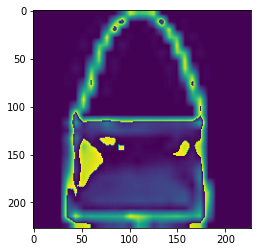

In [8]:
#commentout the normalization in cifar10 train data to see unnormalized img
img = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(img))


## Visualize few Train data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 1, 227, 227])


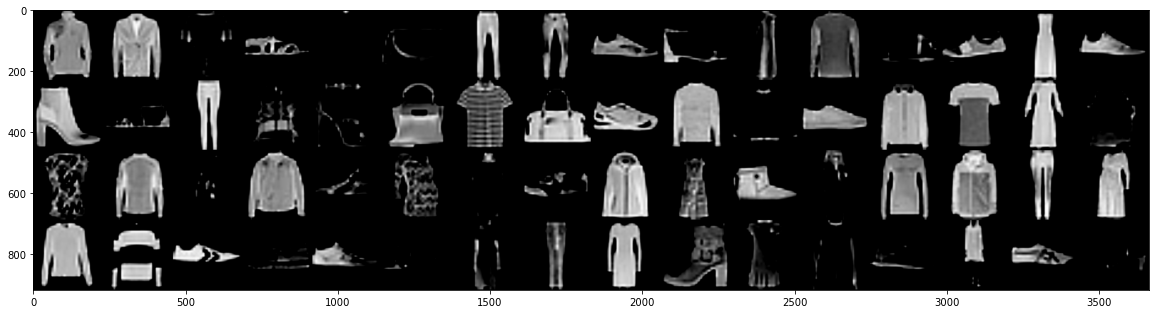

In [9]:
from torchvision.utils import make_grid
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Visualize Valid data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 1, 227, 227])


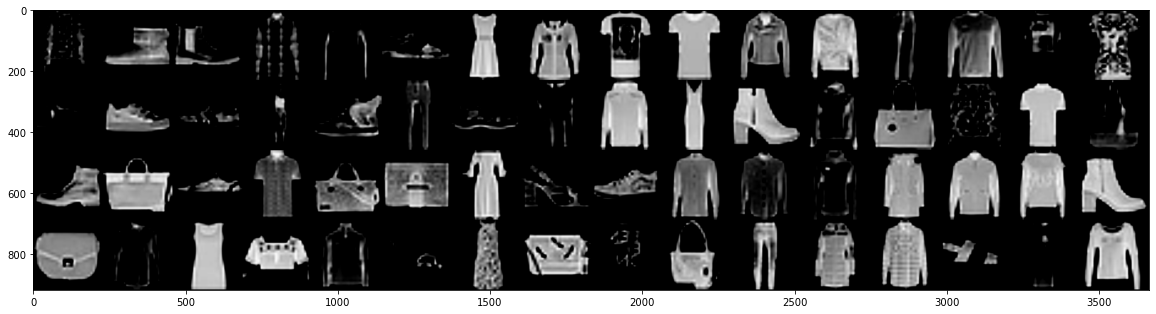

In [10]:
for images, _ in validloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Visualize few Test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 1, 227, 227])


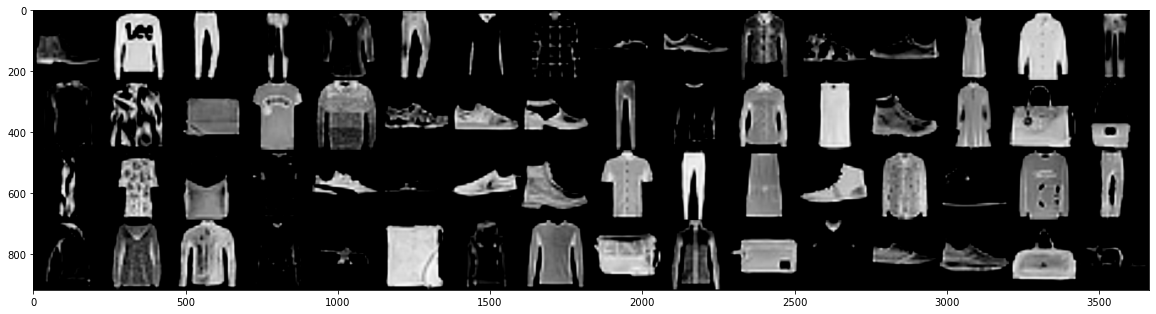

In [11]:
for images, _ in testloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [12]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


## BaseLine net architecture

In [13]:
class net(nn.Module): #take 32*32 input image and 73% validacc with lr=e4, bs=64, epoch=20
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1)
        self.fc1 = nn.Linear(100352, 1024) #512*2*2
        self.fc2 = nn.Linear(1024, 10)
        

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv4(out)), 2)

        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out



## Training Loop

In [14]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader ):
     for epoch in range(1, epoch+1):
         epoch_loss = 0
         for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss +=loss.item()
            
         if epoch == 1 or epoch %10 == 0:
            print(f"Loss in epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()}")
    
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  data = data.to(device=device)
                  label = label.to(device=device)
            ## Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, predicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((predicted == label).sum())
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")

## Losses Learned

For a binary classification, you could either use nn.BCE(WithLogits)Loss and a single output unit or nn.CrossEntropyLoss and two outputs.
Usually nn.CrossEntropyLoss is used for a multi-class classification, but you could treat the binary classification use case as a (multi) 2-class classification, but it’s up to you which approach you would like to use.

If you are using the former approach, we generally recommend to use nn.BCEWithLogitsLoss and pass raw logits to this criterion, as it will yield better numerical stability than sigmoid + nn.BCELoss.

The latter use case also expects raw logits, which can be passed to nn.CrossEntropyLoss

In [15]:
model = net().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
loss_fn = nn.CrossEntropyLoss()


In [16]:

 
TrainingLoop(
      epoch = 20,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      trainloader = trainloader,
 )



Loss in epoch 1 : 0.43720449835062025 : date and time : 2022-04-14 14:33:28.360020
Loss in Valid epoch 1 : 0.35692746433964434 : Got 10355 / 12000 with valid accuracy of :86.29
Loss in epoch 10 : 0.014228859952068887 : date and time : 2022-04-14 15:02:47.890308
Loss in Valid epoch 10 : 0.37904433852452984 : Got 11110 / 12000 with valid accuracy of :92.58
Loss in epoch 20 : 0.006159445266726835 : date and time : 2022-04-14 15:34:13.588465
Loss in Valid epoch 20 : 0.5119374311371815 : Got 11145 / 12000 with valid accuracy of :92.88


In [17]:
torch.save(model.state_dict(), "net_FMNIST.pt") #save the model

In [18]:
model = net()
model.load_state_dict(torch.load("/CV_projects/cifar10/net_FMNIST.pt"))
model.eval()

net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

## Test data prediction

In [19]:

total = 0
correct = 0

with torch.no_grad():
    for imgs, labels in testloader:
                imgs = imgs.to(device="cpu")
                labels = labels.to(device="cpu")
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
    print(
              f"Got {correct} / {total} with test accuracy {float(correct) / float(total) * 100:.2f}"
)


Got 9269 / 10000 with test accuracy 92.69
